# Time Series NO₂ Sentinel-5P untuk Prediksi

Data konsentrasi Nitrogen Dioksida (NO₂) diambil dari satelit Sentinel-5P melalui openEO. Data ini dipakai untuk membangun deret waktu (time series) kualitas udara di wilayah Bangkalan.

Alur pengambilan data:

1. Login ke openEO
Terhubung ke endpoint openeo.dataspace.copernicus.eu menggunakan autentikasi OIDC.

2. Menetapkan Area Kajian (AOI)
Area penelitian di Bangkalan ditentukan dalam bentuk polygon koordinat.

3. Memuat dataset Sentinel-5P
Dataset SENTINEL_5P_L2 diambil dalam rentang tanggal yang ditentukan. Area dimuat dalam bentuk bounding box lebih luas dari AOI untuk menyesuaikan resolusi Sentinel-5P (~7 km).

4. Agregasi waktu (harian)
Nilai NO₂ dalam satu hari dirata-ratakan untuk mendapat satu nilai per tanggal.

5. Agregasi ruang pada AOI
Nilai harian dibatasi hanya untuk area polygon penelitian, lalu dihitung rata-rata spasialnya.

6. Eksekusi dan penyimpanan
Pipeline dieksekusi sebagai batch job, dan output disimpan dalam format .nc (NetCDF) untuk dianalisis lebih lanjut.

In [ ]:
import openeo

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

aoi = {
    "type": "Polygon",
        "coordinates": [
        [
            [
                113.77,
                -6.986
            ],
            [
                113.77,
                -7.053
            ],
            [
                113.89,
                -7.053
            ],
            [
                113.89,
                -6.986
            ],
            [
                113.77,
                -6.986
            ]
        ]
    ],
    "type": "Polygon"
}

s5p_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2023-10-15", "2025-10-19"],
    spatial_extent={
        "west": 113.77,
        "south": -7.053,
        "east": 113.89,
        "north": -6.986
    },
    bands=["NO2"]
)

s5p_no2_daily = s5p_no2.aggregate_temporal_period(
    period="day",
    reducer="mean"
)

s5p_no2_aoi = s5p_no2_daily.aggregate_spatial(
    geometries=aoi,
    reducer="mean"
)

job = s5p_no2.execute_batch(title="NO2 in bangkalan", outputfile="NO2_in_sumenep.nc")

Authenticated using refresh token.
0:00:00 Job 'j-251024064958464bb3b8024fe62a08c6': send 'start'
0:00:14 Job 'j-251024064958464bb3b8024fe62a08c6': queued (progress 0%)
0:00:19 Job 'j-251024064958464bb3b8024fe62a08c6': queued (progress 0%)
0:00:25 Job 'j-251024064958464bb3b8024fe62a08c6': queued (progress 0%)
0:00:34 Job 'j-251024064958464bb3b8024fe62a08c6': queued (progress 0%)
0:00:44 Job 'j-251024064958464bb3b8024fe62a08c6': queued (progress 0%)
0:00:56 Job 'j-251024064958464bb3b8024fe62a08c6': queued (progress 0%)
0:01:12 Job 'j-251024064958464bb3b8024fe62a08c6': running (progress N/A)
0:01:31 Job 'j-251024064958464bb3b8024fe62a08c6': running (progress N/A)
0:01:56 Job 'j-251024064958464bb3b8024fe62a08c6': running (progress N/A)
0:02:26 Job 'j-251024064958464bb3b8024fe62a08c6': running (progress N/A)
0:03:03 Job 'j-251024064958464bb3b8024fe62a08c6': running (progress N/A)
0:03:51 Job 'j-251024064958464bb3b8024fe62a08c6': running (progress N/A)
0:04:49 Job 'j-251024064958464bb3b8024

# Membaca Hasil Ekspor NetCDF dan Mengekstrak Variabel NO₂

Setelah data berhasil diambil dari openEO dan disimpan sebagai NO2_in_bangkalan.nc, langkah berikutnya adalah membuka file tersebut untuk melihat isi dan memahami struktur datanya. Format NetCDF (.nc) lazim digunakan dalam data iklim dan satelit karena mendukung dimensi waktu dan ruang dalam satu berkas.

Langkah inti yang dilakukan:

1. Membuka file .nc
File dimuat menggunakan netCDF4.Dataset agar kontennya bisa diakses.

2. Melihat daftar variabel
Tahap ini untuk mengetahui nama variabel NO₂, variabel waktu, serta metadata lain yang tersedia dalam file.

3. Membaca variabel NO₂ dan waktu
Nilai NO₂ dibaca dalam bentuk array berdimensi (misalnya waktu × latitude × longitude). Data waktu biasanya disimpan sebagai offset terhadap tanggal tertentu.

4. Mengonversi waktu menjadi format tanggal
Jika variabel waktu memiliki atribut units, nilai offset tersebut dikonversi ke objek datetime.

5. Mengecek contoh data
Beberapa elemen pertama ditampilkan untuk memastikan data berhasil terbaca dan sudah dalam format yang benar.

In [ ]:
import netCDF4

file_path = "NO2_in_sumenep.nc"
ds = netCDF4.Dataset(file_path)

print("Variabel dalam file:")
print(ds.variables.keys())

no2 = ds.variables["NO2"][:]

time = ds.variables["t"][:]

try:
    time_units = ds.variables["t"].units
    dates = netCDF4.num2date(time, units=time_units)
except Exception:
    dates = time  

print("\nContoh data pertama:")
for i in range(min(10, len(no2))):
    print(f"{dates[i]} | NO2: {no2[i]}")

Variabel dalam file:
dict_keys(['t', 'x', 'y', 'crs', 'NO2'])

Contoh data pertama:
2023-10-15 00:00:00 | NO2: [[3.6681860819953727e-06 8.782101758697536e-06 9.214637429977302e-06]
 [3.6681860819953727e-06 5.2705122470797505e-06 1.5711264495621435e-05]]
2023-10-16 00:00:00 | NO2: [[1.4460958482231945e-05 1.59431183419656e-05 9.864322237262968e-06]
 [1.4460958482231945e-05 1.0322440175514203e-05 5.526713721337728e-06]]
2023-10-17 00:00:00 | NO2: [[1.620409602764994e-05 2.0299710740800947e-05 1.3298657904670108e-05]
 [1.620409602764994e-05 2.0299710740800947e-05 2.656392643984873e-05]]
2023-10-18 00:00:00 | NO2: [[1.2129868991905823e-05 1.2129868991905823e-05 2.9382636057562195e-06]
 [1.556764436827507e-05 1.8904993339674547e-05 2.9382636057562195e-06]]
2023-10-19 00:00:00 | NO2: [[2.050987859547604e-05 8.023217560548801e-06 8.023217560548801e-06]
 [2.050987859547604e-05 2.050987859547604e-05 2.023958404606674e-05]]
2023-10-20 00:00:00 | NO2: [[7.61882165534189e-06 1.4808022569923196e-05

# Konversi Hasil NetCDF ke Format CSV

Data hasil unduhan dari openEO disimpan dalam format NetCDF (.nc), yang umum digunakan untuk data satelit dan sains bumi karena mampu menyimpan dimensi waktu dan ruang dalam satu file. Meski demikian, format ini kurang praktis jika data akan dianalisis secara statistik sederhana atau divisualisasikan dengan alat seperti Excel atau Pandas.

Oleh karena itu, data NetCDF biasanya dikonversi terlebih dahulu ke format CSV agar lebih mudah dibaca, diolah, dan divisualisasikan dalam workflow analisis yang lebih umum.

In [ ]:
import netCDF4
import pandas as pd
import numpy as np

file_path = "NO2_in_sumenep.nc"
ds = netCDF4.Dataset(file_path)

print(ds)

print(ds.variables.keys())

time_var = ds.variables["t"][:]
no2_var = ds.variables["NO2"][:]

time_units = ds.variables["t"].units
dates = netCDF4.num2date(time_var, units=time_units)

if no2_var.ndim > 1:
    no2_mean = np.nanmean(no2_var, axis=tuple(range(1, no2_var.ndim)))
else:
    no2_mean = no2_var

df = pd.DataFrame({
    "time": dates,
    "NO2": no2_mean
})

df.to_csv("NO2_sumenep.csv", index=False)
print("File NO2_sumenep.csv berhasil dibuat.")
print(df.head())

<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.9
    institution: Copernicus Data Space Ecosystem openEO API - 0.68.0a10.dev20250930+2976
    description: 
    title: 
    dimensions(sizes): t(729), y(2), x(3)
    variables(dimensions): int32 t(t), float64 x(x), float64 y(y), |S1 crs(), float32 NO2(t, y, x)
    groups: 
dict_keys(['t', 'x', 'y', 'crs', 'NO2'])
File NO2_sumenep.csv berhasil dibuat.
                  time       NO2
0  2023-10-15 00:00:00  0.000008
1  2023-10-16 00:00:00  0.000012
2  2023-10-17 00:00:00  0.000019
3  2023-10-18 00:00:00  0.000011
4  2023-10-19 00:00:00  0.000016


# Transformasi Data NO₂ Menjadi Bentuk Supervised Learning

Setelah data NO₂ berhasil dikonversi ke format CSV, langkah berikutnya adalah menyiapkannya untuk pemodelan deret waktu. Pada tahap ini, data disusun ulang agar bisa digunakan oleh model-model berbasis supervised learning seperti LSTM, GRU, atau kombinasi ARIMA–DL (hybrid).

In [ ]:
import pandas as pd

df = pd.read_csv("NO2_sumenep.csv")

df['time'] = pd.to_datetime(df['time'], errors='coerce')

df = df.set_index('time')

df['NO2'] = df['NO2'].interpolate(method='time')

print(df.isna().sum())

n_lags = 4

supervised = pd.DataFrame()

for i in range(n_lags, 0, -1):
    supervised[f'NO2(t-{i})'] = df['NO2'].shift(i)

supervised['NO2(t)'] = df['NO2']

supervised = supervised.dropna()

print("Head of Data:")
print(supervised.head())

print("")
print("Data info:")
supervised.info

NO2    0
dtype: int64
Head of Data:
            NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2023-10-19  0.000008  0.000012  0.000019  0.000011  0.000016
2023-10-20  0.000012  0.000019  0.000011  0.000016  0.000014
2023-10-21  0.000019  0.000011  0.000016  0.000014  0.000019
2023-10-22  0.000011  0.000016  0.000014  0.000019  0.000021
2023-10-23  0.000016  0.000014  0.000019  0.000021  0.000015

Data info:


<bound method DataFrame.info of             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2023-10-19  0.000008  0.000012  0.000019  0.000011  0.000016
2023-10-20  0.000012  0.000019  0.000011  0.000016  0.000014
2023-10-21  0.000019  0.000011  0.000016  0.000014  0.000019
2023-10-22  0.000011  0.000016  0.000014  0.000019  0.000021
2023-10-23  0.000016  0.000014  0.000019  0.000021  0.000015
...              ...       ...       ...       ...       ...
2025-10-14  0.000019  0.000014  0.000009  0.000007  0.000004
2025-10-15  0.000014  0.000009  0.000007  0.000004  0.000007
2025-10-16  0.000009  0.000007  0.000004  0.000007  0.000025
2025-10-17  0.000007  0.000004  0.000007  0.000025  0.000019
2025-10-18  0.000004  0.000007  0.000025  0.000019  0.000017

[725 rows x 5 columns]>

# Normalisasi Data untuk Pemodelan Supervised

Setelah deret waktu NO₂ diubah ke bentuk supervised (misalnya dengan penambahan fitur lag), tahap selanjutnya adalah normalisasi. Teknik yang umum dipakai adalah Min-Max Scaling, yaitu mengubah seluruh nilai ke rentang [0, 1].

Langkah ini penting karena model seperti LSTM dan GRU sangat sensitif terhadap perbedaan skala antar fitur. Dengan normalisasi, pelatihan menjadi lebih stabil dan hasil prediksi cenderung lebih akurat.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

supervised = supervised.reset_index()

normalized_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Sebelum normalisasi:\n", X.head())
print("\nSesudah normalisasi:\n", normalized_df.head())

Sebelum normalisasi:
             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
time                                              
2023-10-19  0.000008  0.000012  0.000019  0.000011
2023-10-20  0.000012  0.000019  0.000011  0.000016
2023-10-21  0.000019  0.000011  0.000016  0.000014
2023-10-22  0.000011  0.000016  0.000014  0.000019
2023-10-23  0.000016  0.000014  0.000019  0.000021

Sesudah normalisasi:
    NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
0  0.517292  0.586720  0.707733  0.569638
1  0.586720  0.707733  0.569638  0.664656
2  0.707733  0.569638  0.664656  0.633113
3  0.569638  0.664656  0.633113  0.706730
4  0.664656  0.633113  0.706730  0.739133


# Pemodelan Time Series NO₂ dengan K-Nearest Neighbors (KNN) Regressor

Setelah data NO₂ dinormalisasi dan disusun dalam format supervised, langkah selanjutnya adalah membangun model peramalan. Pada tahap ini digunakan K-Nearest Neighbors Regressor (KNN) sebagai baseline model.

KNN dipilih sebagai langkah awal karena model ini sederhana, tidak membutuhkan asumsi distribusi data, dan bisa memberikan gambaran awal performa sebelum beralih ke model yang lebih kompleks seperti LSTM atau GRU.

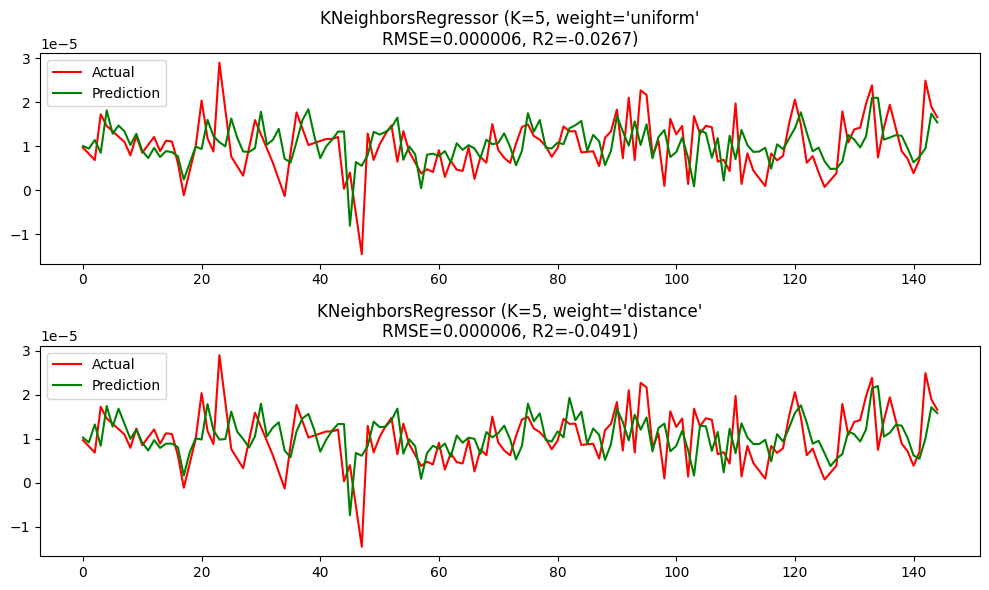

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

n_neighbors = 5

plt.figure(figsize=(10, 6))

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    plt.subplot(2, 1, i + 1)
    plt.plot(range(len(y_test)), y_test, 'red', label="Actual")
    plt.plot(range(len(y_pred)), y_pred, 'green', label="Prediction")
    plt.title(f"KNeighborsRegressor (K={n_neighbors}, weight='{weights}'\nRMSE={rmse:.6f}, R2={r2:.4f})")
    plt.legend()
    plt.tight_layout()

plt.show()